**Disclosures**

The use of TQC+D2RL+ERE was inspired by this various implementations, however this one gave good results on BipedalWalker and was used as a starting point - https://github.com/ArijusLengvenis/bipedal-walker-dreamer/blob/main/dreamer_bipedal_walker_code.ipynb

I made some important changes from this:
* The ERE buffer anneals 'eta' which determins the amount of emphasis to put on recent events. Originally, eta annealed over the course of each episode, then reset for the next one. In contrast, in this implementation eta anneals over the whole training process, and doesn't reset at any point. This is more in line with the original paper I believe.
* I added a Prioritised Experience Replay element to the ERE buffer and removed the Dreamer (which added too much complexity on top of PER)

Key components:
* TQC - Truncated Quantile Critics for Continuous Control (https://bayesgroup.github.io/tqc/)
* ERE - Emphasizing Recent Experience Replay (https://arxiv.org/abs/1906.04009)
* PER - Prioritised Experience Replay (https://arxiv.org/abs/1511.05952)
* D2RL - Dense-to-Sparse Reward Learning (https://sites.google.com/view/d2rl/home)

# **Dependencies and imports**

This can take a minute...

In [ ]:
# https://github.com/robert-lieck/rldurham/tree/main - rldurham source

import sys
if "google.colab" in sys.modules:
    print("Running in Colab, installing dependencies...")
    url = ""
    !wget -O pyproject.toml {url}
    !uv pip install --system -r pyproject.toml

In [3]:
import math
import random
import copy
import time
import os

import matplotlib.pyplot as plt

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import torch.distributions as D
from torch.distributions.transforms import TanhTransform

import rldurham as rld

/Users/Subspace_Explorer/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


# **RL agent**

In [ ]:
MAX_TIMESTEPS = 2000

if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
elif torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
else:
    DEVICE = torch.device("cpu")
DEVICE

device(type='mps')

## helper fns

In [5]:
# reward adjustment
def adjust_reward(reward):
    """
    adjust reward for bipedal walker
    """
    if reward == -100.0: 
        reward = -10.0 # bipedal walker does -100 for hitting floor, so -10 might make it more stable
    else:
        reward *= 2 # encourage forward motion
    return reward

In [ ]:
# training loop function for the environment
def train_on_environment(actor, env, grad_step_class, replay_buffer, max_timesteps,
    state, batch_size, total_steps, init_rand_steps=None,
    ):
    '''
    Abstracted training loop function for the environment.

    Based on https://github.com/ArijusLengvenis/bipedal-walker-dreamer/blob/main/dreamer_bipedal_walker_code.ipynb

    '''
    ep_timesteps = 0
    ep_reward = 0

    state_dim = actor.state_dim
    act_dim = actor.action_dim

    # initial state float32 for mps
    state = state.astype(np.float32)

    for t in range(max_timesteps): 
        total_steps += 1
        ep_timesteps += 1

        # select action and step the env
        if init_rand_steps is not None and total_steps < init_rand_steps: # do random steps at start for warm-up
            action = env.action_space.sample()
        else: # otherwise use actor policy
            action = actor.select_action(state)

        step = env.step(action)

        # handle different return formats
        if len(step) == 5:
            next_state, reward, term, tr, info = step
            done = term or tr
        else:
            next_state, reward, done, info = step

        # float32 for mps
        next_state = next_state.astype(np.float32)
        reward = float(reward) # extrinsic reward
        done = float(done)

        ep_reward += reward # sum extrinsic reward

        reward = adjust_reward(reward) # adjust reward for bipedal walker
        replay_buffer.add(state, action, next_state, reward, done) # add to replay buffer

        state = next_state
        
        # train step if buffer has enough samples for a batch AND we're past warmup
        if total_steps >= batch_size and init_rand_steps is not None and total_steps >= init_rand_steps:
            # train the agent using experiences from the real environment
            grad_step_class.take_gradient_step(replay_buffer, total_steps, batch_size)
    
        if done: # break if finished
            break

    # only return extrinsic to eval based on that
    return ep_timesteps, ep_reward, info

## replay buffer

In [ ]:
class EREPER_ReplayBuffer(object):
    '''
    ERE implementation - https://github.com/ArijusLengvenis/bipedal-walker-dreamer/blob/main/dreamer_bipedal_walker_code.ipynb
    ERE paper - https://arxiv.org/abs/1906.04009
    
    Prioritized Experience Replay (PER) buffer, as in https://arxiv.org/abs/1511.05952.
    Implementation: https://github.com/BY571/Soft-Actor-Critic-and-Extensions/blob/master/SAC_PER.py
        PER parameters are sourced from this implementation.


    Rationale:
    - actions from early in training are likely v different to optimal, so want to prioritise recent ones so we're not constantly learning from crap ones
    - as time goes on, they get more similar so annealing eta allows uniform sampling later on
    '''
    def __init__(self, state_dim, action_dim, T, max_size, eta, cmin, use_per=True,
                beta_1=0.6, beta_2_start=0.4, beta_2_frames=int(1e5), epsilon=1e-6, recency_scale=1):

        self.max_size, self.ptr, self.size, self.rollover = max_size, 0, 0, False
        self.use_per = use_per # use PER flag
        
        # ERE params
        self.eta0 = eta
        self.cmin = cmin
        self.T = T
        self.recency_scale = recency_scale # when using PER too, this helps calculate ck

        # PER params
        self.beta_1 = beta_1
        self.beta_2_start = beta_2_start
        self.beta_2_frames = beta_2_frames
        self.epsilon = epsilon
        self.frame = 1 # for beta calculation

        # storage
        self.reward = np.empty((max_size, 1), dtype=np.float32) # float32 for mps
        self.state = np.empty((max_size, state_dim), dtype=np.float32)
        self.action = np.empty((max_size, action_dim), dtype=np.float32)
        self.not_done = np.empty((max_size, 1), dtype=np.float32)
        self.next_state = np.empty((max_size, state_dim), dtype=np.float32)
        self.priorities = np.zeros((max_size, 1), dtype=np.float32) # for PER
        self.max_prio = 1.0 # max priority seen so far

    def eta_anneal(self, t):
        # eta anneals over time --> 1, which reduces emphasis on recent experiences over time
        return min(1.0, self.eta0 + (1 - self.eta0) * t / self.T)

    def beta_2_by_frame(self, frame_idx):
        """
        Linearly increases beta from beta_2_start to 1 over time from 1 to beta_2_frames.
        
        see 3.4 ANNEALING THE BIAS (Paper: PER)
        """
        return min(1.0, self.beta_2_start + frame_idx * (1.0 - self.beta_2_start) / self.beta_2_frames)
 
    def add(self, state, action, next_state, reward, done):
        # Add experience to replay buffer 
        self.state[self.ptr] = state.astype(np.float32)
        self.action[self.ptr] = action.astype(np.float32)
        self.next_state[self.ptr] = next_state.astype(np.float32)
        self.reward[self.ptr] = float(reward)
        self.not_done[self.ptr] = 1. - float(done)
        self.priorities[self.ptr] = self.max_prio if self.size > 0 else 1.0 # gives max priority if buffer is not empty else 1

        self.ptr += 1
        self.ptr %= self.max_size

        # increase size counter until full, then start overwriting (rollover)
        if self.max_size > self.size + 1:
          self.size += 1
        else:
          self.size = self.max_size
          self.rollover = True

    def sample(self, batch_size, t):
        # update eta value for current timestep
        eta = self.eta_anneal(t)

        # ERE -----
        # get ck
        c_calc = self.size * eta ** (t / self.T * self.recency_scale)
        ck = int(max(self.cmin, c_calc)) # at least cmin samples
        ck = min(ck, self.size) # limit to buffer size

        # get indices within the recent window and handle rollover
        if not self.rollover:
            # buffer not yet full, window is [size - ck, size)
            indices = np.arange(max(0, self.size - ck), self.size)
        else:
            # Buffer has rolled over, window wraps around
            start_idx = (self.ptr - ck + self.max_size) % self.max_size
            if start_idx < self.ptr:
                indices = np.arange(start_idx, self.ptr)
            else:
                indices = np.concatenate((np.arange(start_idx, self.max_size), np.arange(0, self.ptr)))

        # ensure ck matches the actual number of indices determined
        ck = len(indices)

        # PER -----
        if self.use_per:
            # calc P = p^a/sum(p^a)
            prios = self.priorities[indices].flatten() + self.epsilon # add epsilon to avoid zero probs
            probs = prios ** self.beta_1
            probs_sum = probs.sum()
            if probs_sum <= 0: # avoid division by zero if all prios = zero
                P = np.ones(ck, dtype=np.float32) / ck # uniform sample
            else:
                P = probs / probs_sum
            
            # gets the indices depending on the probability p and the c_k range of the buffer
            rel_indices = np.random.choice(ck, batch_size, p=P, replace=True)
            samples = indices[rel_indices]
            
            beta_2 = self.beta_2_by_frame(self.frame)
            self.frame += 1 # incremement for annealing
                    
            # Compute importance-sampling weights w = (N * P)^(-beta_2)
            weights  = (ck * P[rel_indices]) ** (-beta_2)
            # normalize weights
            weights /= weights.max() 
            weights = np.array(weights, dtype=np.float32)
        else:
            # otherwise sample uniformly like in basic ere
            rel_indices = np.random.choice(ck, batch_size, replace=True)
            samples = indices[rel_indices]
            # return weights of 1
            weights = np.ones(batch_size, dtype=np.float32)


        r = torch.tensor(self.reward[samples], dtype=torch.float32).to(DEVICE)
        s = torch.tensor(self.state[samples], dtype=torch.float32).to(DEVICE)
        ns = torch.tensor(self.next_state[samples], dtype=torch.float32).to(DEVICE)
        a = torch.tensor(self.action[samples], dtype=torch.float32).to(DEVICE)
        nd = torch.tensor(self.not_done[samples], dtype=torch.float32).to(DEVICE)
        
        return s, a, ns, r, nd, samples, weights

    def update_priorities(self, batch_indices, batch_priorities):
        priorities = np.abs(batch_priorities) + self.epsilon # ensure > 0

        self.priorities[batch_indices] = priorities.reshape(-1, 1) 
        self.max_prio = max(self.max_prio, np.max(priorities)) # update max prio


## agent

**actor-critic**

In [8]:
# LOSS
# https://github.com/ArijusLengvenis/bipedal-walker-dreamer/blob/main/dreamer_bipedal_walker_code.ipynb

def quantile_huber_loss(quantiles, samples, sum_over_quantiles=False):
    '''
    From TQC (see paper p3)
    Specific implementation: https://github.com/Stable-Baselines-Team/stable-baselines3-contrib/blob/master/sb3_contrib/common/utils.py#L8

    Huber loss is less sensitive to outliers than MSE

    samples: (batch_size, 1, n_target_quantiles) -> (batch_size, 1, 1, n_target_quantiles)
    quantiles: (batch_size, n_critics, n_quantiles) -> (batch_size, n_critics, n_quantiles, 1)
    pairwise_delta: (batch_size, n_critics, n_quantiles, n_target_quantiles)
    '''
    # uses a squared term if the absolute element-wise error falls below delta and a delta-scaled L1 term otherwise
    delta = samples.unsqueeze(1) - quantiles.unsqueeze(3) # (batch_size, 1, 1, n_target_quantiles) - (batch_size, n_critics, n_quantiles, 1)
    abs_delta = torch.abs(delta)
    huber_loss = torch.where(abs_delta > 1., abs_delta - 0.5, delta ** 2 * 0.5) # 1.0 as threshold k for Huber loss
    n_quantiles = quantiles.shape[2]

    # cumulative probabilities to calc quantiles
    cum_prob = (torch.arange(n_quantiles, device=quantiles.device, dtype=torch.float) + 0.5) / n_quantiles
    cum_prob = cum_prob.view(1, 1, -1, 1) # quantiles has shape (batch_size, n_critics, n_quantiles), so make cum_prob broadcastable to (batch_size, n_critics, n_quantiles, n_target_quantiles)
    
    # Calculate quantile loss: |τ - I(δ < 0)| * L_k(δ)
    # τ = cum_prob, I(δ < 0) = (delta < 0).float(), L_k(δ) = huber_loss
    loss = (torch.abs(cum_prob - (delta < 0).float()) * huber_loss)

    # Summing over the quantile dimension 
    if sum_over_quantiles:
        # sum over quantiles
        # then average over target quantiles
        loss = loss.sum(dim=2).mean(dim=2) # (batch_size, n_critics)
    else:
        loss = loss.mean()

    return loss

In [ ]:
# https://github.com/ArijusLengvenis/bipedal-walker-dreamer/blob/main/dreamer_bipedal_walker_code.ipynb

# MLP for actor that implements D2RL architecture
class ActorMLP(nn.Module):
  def __init__(self, input_dim, hidden_dims, output_dim):
    # input size = state dim, output size = action dim
    super().__init__()
    self.layer_list = nn.ModuleList()
    self.input_dim = input_dim

    current_dim = input_dim # first layer has input dim = state dim
    for i, next_size in enumerate(hidden_dims):
      layer = nn.Linear(current_dim, next_size).to(DEVICE)
      self.layer_list.append(layer)
      current_dim = next_size + self.input_dim # prev layers output + original input size
        
    # Final layer input dim is last hidden layer output + original input size
    self.last_layer_mean_linear = nn.Linear(current_dim, output_dim).to(DEVICE)
    self.last_layer_log_std_linear = nn.Linear(current_dim, output_dim).to(DEVICE)

  def forward(self, input_):
    curr = input_
    for layer in self.layer_list:
      curr = F.gelu(layer(curr))
      curr = torch.cat([curr, input_], dim=1) # cat with output layer

    mean_linear = self.last_layer_mean_linear(curr)
    log_std_linear = self.last_layer_log_std_linear(curr)
    return mean_linear, log_std_linear

# MLP for critic that implements D2RL architecture 
class CriticMLP(nn.Module):
  def __init__(self, input_dim, hidden_dims, output_dim):
    # input size = state dim + action dim, output size = n_quantiles
    super().__init__()
    self.layer_list = nn.ModuleList()
    self.input_dim = input_dim

    current_dim = input_dim
    for i, next_size in enumerate(hidden_dims):
      layer = nn.Linear(current_dim, next_size).to(DEVICE)
      self.layer_list.append(layer)
      current_dim = next_size + self.input_dim

    self.last_layer = nn.Linear(current_dim, output_dim).to(DEVICE)

  def forward(self, input_):
    curr = input_
    for layer in self.layer_list:
      curr = F.gelu(layer(curr))
      curr = torch.cat([curr, input_], dim=1)
      
    output = self.last_layer(curr)
    return output


In [10]:
# https://github.com/ArijusLengvenis/bipedal-walker-dreamer/blob/main/dreamer_bipedal_walker_code.ipynb

class GradientStep(object):
  '''
  see (D2RL) https://github.com/pairlab/d2rl/blob/main/sac/sac.py
  and (TQC) https://github.com/Stable-Baselines-Team/stable-baselines3-contrib/blob/master/sb3_contrib/tqc/tqc.py
  '''
  def __init__(self,*,
    actor, critic, critic_target, discount, tau,
    actor_lr, critic_lr, alpha_lr,
    n_quantiles, n_mini_critics, top_quantiles_to_drop_per_net, target_entropy,
    use_per=True
    ):

    self.actor = actor
    self.critic = critic
    self.critic_target = critic_target
    self.use_per = use_per

    self.log_alpha = nn.Parameter(torch.zeros(1).to(DEVICE)) # log alpha is learned
    self.quantiles_total = n_quantiles * n_mini_critics
    
    self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=actor_lr)
    self.alpha_optimizer = optim.Adam([self.log_alpha], lr=alpha_lr)
    self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=critic_lr)

    self.discount, self.tau = discount, tau
    self.top_quantiles_to_drop = top_quantiles_to_drop_per_net * n_mini_critics # total number of quantiles to drop
    self.target_entropy = target_entropy

  def take_gradient_step(self, replay_buffer, total_steps, batch_size=256):
    # Sample batch from replay buffer
    state, action, next_state, reward, not_done, indices, weights = replay_buffer.sample(batch_size, total_steps)
    weights = torch.tensor(weights, dtype=torch.float32).to(DEVICE).unsqueeze(1) # PER weights. add dim for broadcast
    alpha = torch.exp(self.log_alpha) # entropy temperature coefficient

    with torch.no_grad():
      # sample new action from actor on next state
      new_next_action, next_log_pi = self.actor(next_state)

      # Compute and cut quantiles at the next state
      next_z = self.critic_target(next_state, new_next_action)
      
      # Sort and drop top k quantiles to control overestimation (TQC)
      sorted_z, _ = torch.sort(next_z.reshape(batch_size, -1))
      sorted_z_part = sorted_z[:, :self.quantiles_total-self.top_quantiles_to_drop] # estimated truncated Q-val dist for next state

      # td error + entropy term
      target = reward + not_done * self.discount * (sorted_z_part - alpha * next_log_pi)
    
    # Get current quantile estimates using action from the replay buffer
    cur_z = self.critic(state, action)
    per_critic_loss = quantile_huber_loss(cur_z, target.unsqueeze(1), sum_over_quantiles=True) # keep quantile dim for now
    critic_loss = (per_critic_loss * weights).mean() # PER loss

    new_action, log_pi = self.actor(state)
    # detach the variable from the graph so we don't change it with other losses
    alpha_loss = -(self.log_alpha * (log_pi + self.target_entropy).detach()).mean() # as in D2RL implementation for auto entropy tuning

    # Optimise critic
    self.critic_optimizer.zero_grad()
    critic_loss.backward()
    self.critic_optimizer.step()

    # update PER prios
    if self.use_per and indices is not None:
      avg_critic_loss = per_critic_loss.mean(1) # average over critics
      new_prios = avg_critic_loss.detach().cpu().numpy()
      replay_buffer.update_priorities(indices, new_prios)

    # Soft update target networks
    for param, target_param in zip(self.critic.parameters(), self.critic_target.parameters()):
      target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)
    
    # Compute actor (π) loss
    # Jπ = 𝔼st∼D,εt∼N[α * logπ(f(εt;st)|st) − Q(st,f(εt;st))]
    actor_loss = (alpha * log_pi - self.critic(state, new_action).mean(2).mean(1, keepdim=True)).mean()
    # ^ mean(2) is over quantiles, mean(1) is over critic ensemble
    
    # Optimise the actor
    self.actor_optimizer.zero_grad()
    actor_loss.backward()
    self.actor_optimizer.step()

    # Optimise the entropy coefficient
    self.alpha_optimizer.zero_grad()
    alpha_loss.backward()
    self.alpha_optimizer.step()


In [ ]:
# https://github.com/ArijusLengvenis/bipedal-walker-dreamer/blob/main/dreamer_bipedal_walker_code.ipynb

class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dims=[512, 512]):
        super().__init__()
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.mlp = ActorMLP(state_dim, hidden_dims, action_dim)

    def forward(self, obs):
        mean, log_std = self.mlp(obs)
        log_std = log_std.clamp(-20, 2) # clamp for stability
        std = torch.exp(log_std)

        base_N_dist = D.Normal(mean, std) # base normal dist
        tanh_transform = TanhTransform(cache_size=1) # transform to get the tanh dist

        log_prob = None
        if self.training: # i.e. agent.train()
            transformed_dist = D.TransformedDistribution(base_N_dist, tanh_transform) # transformed distribution
            action = transformed_dist.rsample() # samples from base dist & applies transform
            log_prob = transformed_dist.log_prob(action) # log prob of action after transform
            log_prob = log_prob.sum(dim=1, keepdim=True) # sum over action dim
        else: # evaluation mode
            action = torch.tanh(mean)
            
        return action, log_prob

    def select_action(self, obs):
        obs = torch.tensor(obs, dtype=torch.float32).to(DEVICE)
        if obs.ndim == 1: # add batch dim if missing
             obs = obs.unsqueeze(0)
        act, _ = self.forward(obs)
        return np.array(act[0].cpu().detach())


class Critic(nn.Module): # really a mega-critic from lots of mini-critics
    '''
    Ensemble of critics for TQC
    '''
    def __init__(self, state_dim, action_dim, n_quantiles, n_nets, hidden_dims=[256, 256]):
        super().__init__()
        self.critics = nn.ModuleList()
        self.n_quantiles = n_quantiles

        for _ in range(n_nets): # multiple critic mlps
            net = CriticMLP(state_dim + action_dim, hidden_dims, n_quantiles)
            self.critics.append(net)

    def forward(self, state, action):
        # cat state and action (to pass to critic)
        state_act = torch.cat((state, action), dim=1)

        # pool quantiles from each critic mlp
        quantiles = [critic(state_act) for critic in self.critics]
        quantiles = torch.stack(quantiles, dim=1) # stack into tensor
        return quantiles


# Parameters and Training

**Prepare the environment and wrap it to capture statistics, logs, and videos**

In [ ]:
# My hyperparams
seed = 42

hyperparams = {
    # env/general params
    "max_timesteps": MAX_TIMESTEPS, # per episode
    "max_episodes": 1000,
    "target_score": 300, # stop training when average score over r_list > target_score
    "len_r_list": 100, # length of reward list to average over for target score (stop training when avg > target_score)
    "hardcore": True, # fixed in wandb sweep
    "init_rand_steps": 10000, # number of steps to take with random actions before training (helps exploration)

    # Agent hyperparams 
    "n_mini_critics": 5, # each mini-critic is a single mlp, which combine to make one mega-critic
    "n_quantiles": 20, # quantiles per mini critic
    "top_quantiles_to_drop_per_net": 'auto', # per mini critic (auto based on n_quantiles)
    "actor_hidden_dims": [512, 512],
    "mini_critic_hidden_dims": [256, 256], # * n_mini_critics
    "batch_size": 256,
    "discount": 0.98, # gamma
    "tau": 0.005,
    "actor_lr": 3.29e-4, # empirically chosen
    "critic_lr": 3.5e-4, # empirically chosen
    "alpha_lr": 3.24e-4, # empirically chosen

    # ERE buffer (see paper for their choices)
    "use_per": True, # use PER sampling as well
    "buffer_size": 1000000, # smaller size improves learning early on but is outperformed later on
    "eta0": 0.996, # 0.994 - 0.999 is good (according to paper)
    "annealing_steps": 'auto', # number of steps to anneal eta over (after which sampling is uniform) - None = auto-set to max estimated steps in training
    "cmin": 5000, # min number of samples to sample from
    "recency_scale": 1, # scale factor for recency
}

# recording/logging
plot_interval = 10 # plot every Nth episode
save_fig = False # save figures too

is_recording = True # record videos of agent
if hyperparams['hardcore']:
    video_interval = 30 # record every Nth episode
    ep_start_rec = 500 # start recording on this episode
else:
    video_interval = 20
    ep_start_rec = 50

if hyperparams['annealing_steps'] == 'auto':
    hyperparams['annealing_steps'] = hyperparams['max_episodes']*hyperparams['max_timesteps'] # max est number of steps in training
if hyperparams['top_quantiles_to_drop_per_net'] == 'auto':
    hyperparams['top_quantiles_to_drop_per_net'] = int(hyperparams['n_quantiles'] // 12.5) # keep ratio same as M=25 d=2 (from TQC paper)

The device is: cpu (as recommended)
actions are continuous with 4 dimensions/#actions
observations are continuous with 24 dimensions/#observations
maximum timesteps is: None


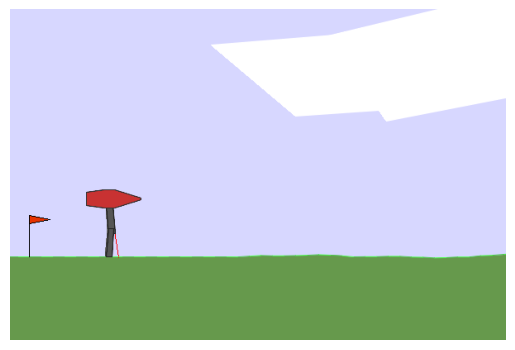

In [ ]:
## SETUP

# make env
env = rld.make("rldurham/Walker", render_mode="rgb_array", hardcore=hyperparams['hardcore'])

# get statistics, logs, and videos
video_prefix = "nchw73-agent-hardcore-video" if hyperparams['hardcore'] else "nchw73-agent-video"
env = rld.Recorder(
    env,
    smoothing=10,                       # track rolling averages (useful for plotting)
    video=True,                         # enable recording videos
    video_folder="videos",              # folder for videos
    video_prefix=video_prefix,          # prefix for videos
    logs=True,                          # keep logs
)

rld.check_device() # training on CPU recommended

env.video = False # switch video recording off (only switch on every x episodes as this is slow)

# environment info
discrete_act, discrete_obs, act_dim, state_dim = rld.env_info(env, print_out=True)

# render start image
env.reset(seed=seed)
rld.render(env)

**Training**

In [ ]:
# in the submission please use seed_everything with seed 42 for verification
seed, state, info = rld.seed_everything(seed, env)

# track statistics for plotting
tracker = rld.InfoTracker()

replay_buffer = EREPER_ReplayBuffer(
    state_dim, act_dim, hyperparams['annealing_steps'], hyperparams['buffer_size'], hyperparams['eta0'], hyperparams['cmin'],
    use_per=hyperparams['use_per'], recency_scale=hyperparams['recency_scale'],
    )

actor = Actor(state_dim, act_dim, hyperparams['actor_hidden_dims']).to(DEVICE)

critic = Critic(
    state_dim, act_dim, hyperparams['n_quantiles'], hyperparams['n_mini_critics'], hyperparams['mini_critic_hidden_dims']
    ).to(DEVICE)
critic_target = copy.deepcopy(critic)

target_entropy = -np.prod(env.action_space.shape).item() # target entropy heuristic = −dim(A) (as in SAC paper)

grad_step_class = GradientStep(
    actor=actor, critic=critic, critic_target=critic_target,
    discount=hyperparams['discount'], tau=hyperparams['tau'],
    actor_lr=hyperparams['actor_lr'], critic_lr=hyperparams['critic_lr'], alpha_lr=hyperparams['alpha_lr'],
    n_quantiles=hyperparams['n_quantiles'], n_mini_critics=hyperparams['n_mini_critics'],
    top_quantiles_to_drop_per_net=hyperparams['top_quantiles_to_drop_per_net'],
    target_entropy=target_entropy, use_per=hyperparams['use_per'],
    )

actor.train()

total_steps = 0
memory_ptr = 0 # marks boundary between new and old data in the replay buffer
recent_rewards= []
completed_env = False

episode = 1


Seed set to 42


In [ ]:
# training loop
while episode <= hyperparams['max_episodes']: # index from 1
    # recording statistics and video can be switched on and off (video recording is slow!)
    if is_recording and episode >= ep_start_rec:
        env.info = episode % video_interval == 0   # track every x episodes (usually tracking every episode is fine)
        env.video = episode % video_interval == 0  # record videos every x episodes (set BEFORE calling reset!)

    # reset for new episode
    state, info = env.reset()
    state = state.astype(np.float32) # float32 for mps

    # sample real env
    ep_timesteps, ep_reward, info = train_on_environment(
        actor, env, grad_step_class, replay_buffer, hyperparams['max_timesteps'], state,
        hyperparams['batch_size'], total_steps, hyperparams['init_rand_steps'],
        )

    total_steps += ep_timesteps
    tracker.track(info) # track statistics for plotting

    memory_ptr = replay_buffer.ptr # update the memory pointer to the current position in the buffer

    # print(f"Ep: {episode} | Timesteps: {ep_timesteps} | Reward: {ep_reward:.3f} | Total Steps: {total_steps:.2g}")
   
    # plot tracked statistics (on real env)
    if episode % plot_interval == 0 or completed_env or episode == hyperparams['max_episodes']: # always save last plot
        # save as well (show=False returns it but doesnt display)
        if save_fig and info: # check info isnt {} (i.e. not None)
            fig, _ = tracker.plot(show=False, r_mean_=True, r_std_=True, r_sum=dict(linestyle=':', marker='x'))
            fig_suffix = '_hardcore' if hyperparams['hardcore'] else ''
            fig.savefig(f'./tracker_nchw73{fig_suffix}.png', bbox_inches = 'tight')
            plt.close(fig) # Close the figure to free memory
        # show by default
        tracker.plot(r_mean_=True, r_std_=True, r_sum=dict(linestyle=':', marker='x'))

    recent_rewards.append(ep_reward)
    current_avg = np.array(recent_rewards).mean()

    # env completion (break) condition - stop if we consistently meet target score
    if len(recent_rewards) >= hyperparams['len_r_list']:
        print(f'Current progress: {current_avg:.3f} / {hyperparams["target_score"]}')
        if current_avg >= hyperparams['target_score']: # quit when we've got good enough performance
            print(f"Completed environment in {episode} episodes!")
            completed_env = True # ensure final plot is saved
            break
        recent_rewards = recent_rewards[-hyperparams['len_r_list']+1:] # discard oldest on list (keep most recent 99)        
    
    
    episode += 1

# don't forget to close environment (e.g. triggers last video save)
env.close()

# write log file
if hyperparams['hardcore']:
    filename = "nchw73-agent-hardcore-log.txt"
else:
    filename = "nchw73-agent-log.txt"
env.write_log(folder="logs", file=filename)


Ep: 14 | Timesteps: 55 | Reward: -110.106 | Total Steps: 1.1e+04
Ep: 15 | Timesteps: 2000 | Reward: -72.884 | Total Steps: 1.3e+04
Ep: 16 | Timesteps: 2000 | Reward: -68.794 | Total Steps: 1.5e+04
Ep: 17 | Timesteps: 59 | Reward: -101.857 | Total Steps: 1.5e+04
Ep: 18 | Timesteps: 72 | Reward: -98.471 | Total Steps: 1.5e+04
Ep: 19 | Timesteps: 63 | Reward: -98.943 | Total Steps: 1.5e+04


KeyboardInterrupt: 